In [1]:
import ray 
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [2]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2025-08-15 12:39:01,113	INFO worker.py:1917 -- Started a local Ray instance.


Python version:,3.11.13
Ray version:,2.47.1


In [3]:
ray.cluster_resources()

{'object_store_memory': 9106151424.0,
 'accelerator_type:P100': 1.0,
 'node:172.19.2.2': 1.0,
 'CPU': 4.0,
 'memory': 21247686656.0,
 'GPU': 1.0,
 'node:__internal_head__': 1.0}

In [4]:
# Workers 
num_workers = 1
resources_per_worker={"CPU": 4, "GPU": 1}

In [5]:
# Data ingestion
DATASET_LOC = "/kaggle/input/dataset/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [6]:
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [7]:
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [8]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [9]:
train_proportions = train_df.tag.value_counts(normalize=True)

val_proportions = val_df.tag.value_counts(normalize=True)

print(train_proportions)
print(val_proportions)

tag
natural-language-processing    0.405892
computer-vision                0.373159
other                          0.139116
mlops                          0.081833
Name: proportion, dtype: float64
tag
natural-language-processing    0.405229
computer-vision                0.372549
other                          0.137255
mlops                          0.084967
Name: proportion, dtype: float64


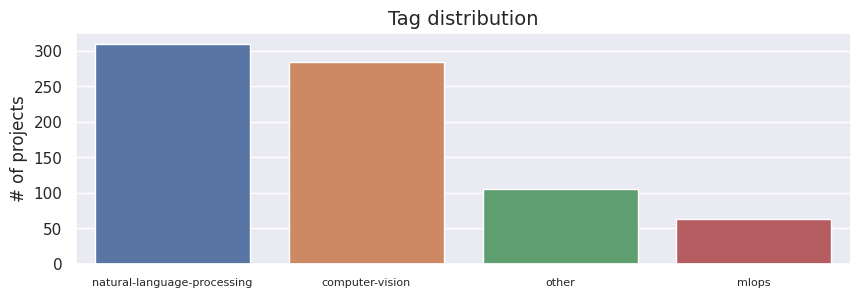

In [10]:
all_tags = Counter(df.tag)
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()


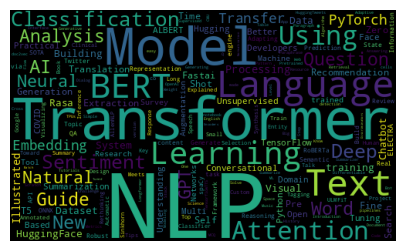

In [11]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)


In [12]:
df["text"] = df.title + " " + df.description

In [13]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def clean_text(text, stopwords=STOPWORDS):
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text

In [15]:
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [16]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


In [17]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [18]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [19]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [20]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

In [21]:
import numpy as np
from transformers import BertTokenizer

In [22]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [23]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [24]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2])}

In [25]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [26]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1

### Distributed preprocessing

In [27]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [28]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2025-08-15 12:39:13,984	INFO dataset.py:3046 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2025-08-15 12:39:14,016	INFO logging.py:295 -- Registered dataset logger for dataset dataset_2_0
2025-08-15 12:39:14,095	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_2_0. Full logs are in /tmp/ray/session_2025-08-15_12-38-57_175082_36/logs/ray-data
2025-08-15 12:39:14,096	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_2_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- ReadCSV->SplitBlocks(8) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- limit=1 5: 0.00 row [00:00, ? row/s]

2025-08-15 12:39:16,711	INFO streaming_executor.py:227 -- ✔️  Dataset dataset_2_0 execution finished in 2.61 seconds


[{'id': 1045,
  'created_on': datetime.datetime(2020, 5, 30, 1, 35, 24),
  'title': 'Illustrated Guide to Transformers: Step by Step Explanation',
  'description': 'In this post, we’ll focus on the one paper that started it all, “Attention is all you need”.',
  'tag': 'natural-language-processing'}]

In [29]:
from ray.data import Dataset
from typing import Dict, List, Tuple

def stratify_split(
    ds: Dataset,
    stratify: str,
    test_size: float,
    shuffle: bool = True,
    seed: int = 1234,
) -> Tuple[Dataset, Dataset]:

    def _add_split(df: pd.DataFrame) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Naively split a dataframe into train and test splits.
        Add a column specifying whether it's the train or test split."""
        train, test = train_test_split(df, test_size=test_size, shuffle=shuffle, random_state=seed)
        train["_split"] = "train"
        test["_split"] = "test"
        return pd.concat([train, test])

    def _filter_split(df: pd.DataFrame, split: str) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Filter by data points that match the split column's value
        and return the dataframe with the _split column dropped."""
        return df[df["_split"] == split].drop("_split", axis=1)

    # Train, test split with stratify
    grouped = ds.groupby(stratify).map_groups(_add_split, batch_format="pandas")  # group by each unique value in the column we want to stratify on
    train_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "train"}, batch_format="pandas")  # combine
    test_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "test"}, batch_format="pandas")  # combine

    # Shuffle each split (required)
    train_ds = train_ds.random_shuffle(seed=seed)
    test_ds = test_ds.random_shuffle(seed=seed)

    return train_ds, test_ds

In [30]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

In [31]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2025-08-15 12:39:16,825	INFO logging.py:295 -- Registered dataset logger for dataset dataset_11_0
2025-08-15 12:39:16,833	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_11_0. Full logs are in /tmp/ray/session_2025-08-15_12-38-57_175082_36/logs/ray-data
2025-08-15 12:39:16,834	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_11_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- ReadCSV->SplitBlocks(8) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Sort 5: 0.00 row [00:00, ? row/s]

Sort Sample 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 8:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9: 0.00 row [00:00, ? row/s]

Shuffle Map 10:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 11:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Aggregate 12: 0.00 row [00:00, ? row/s]

Sort Sample 13:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 14:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 15:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- limit=1 16: 0.00 row [00:00, ? row/s]

2025-08-15 12:39:17,040	WARNING progress_bar.py:120 -- Truncating long operator name to 100 characters. To disable this behavior, set `ray.data.DataContext.get_current().DEFAULT_ENABLE_PROGRESS_BAR_NAME_TRUNCATION = False`.
2025-08-15 12:39:18,242	INFO streaming_executor.py:227 -- ✔️  Dataset dataset_11_0 execution finished in 1.41 seconds


In [32]:
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

2025-08-15 12:39:18,296	INFO logging.py:295 -- Registered dataset logger for dataset dataset_13_0
2025-08-15 12:39:18,305	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_13_0. Full logs are in /tmp/ray/session_2025-08-15_12-38-57_175082_36/logs/ray-data
2025-08-15 12:39:18,306	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_13_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- ReadCSV->SplitBlocks(8) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Sort 5: 0.00 row [00:00, ? row/s]

Sort Sample 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 8:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9: 0.00 row [00:00, ? row/s]

Shuffle Map 10:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 11:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(preprocess) 12: 0.00 row [00:00, ? row/s]

- limit=1 13: 0.00 row [00:00, ? row/s]

2025-08-15 12:39:24,509	INFO streaming_executor.py:227 -- ✔️  Dataset dataset_13_0 execution finished in 6.20 seconds


{'ids': array([  102,   239, 30118, 10248, 20168,   907,  1232,  1572,  2848,
         239, 30118, 10248, 20168,   907,  1232,  1572,   487,  5702,
        2112,   255,   103,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 1}
